In [8]:
import mariadb
import sys
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, Normalizer
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, RocCurveDisplay
from sklearn.tree import DecisionTreeClassifier 
from sklearn.linear_model import LogisticRegression
import datetime
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import mlflow
from mlflow.models import infer_signature
from mlflow.data.pandas_dataset import PandasDataset
from mlflow import MlflowClient
from sklearn import datasets
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from xgboost import XGBClassifier
import seaborn as sns
import os


In [9]:
# Connect to MariaDB Platform
try:
    connection = mariadb.connect(
        user="root",
        password="root",
        host="127.0.0.1",
        port=3306,
        database="tawos_cleaned"

    )
except mariadb.Error as e:
    print(f"Error connecting to MariaDB Platform: {e}")
    sys.exit(1)

In [10]:
def get_rows(db):
    """ Permet de retourner les enregistrements de la table data_cleaned2 """
    cur  = db.cursor()
    columns = []
    cur.execute("SELECT `COLUMN_NAME` FROM `INFORMATION_SCHEMA`.`COLUMNS` WHERE `TABLE_SCHEMA`='tawos_cleaned' AND `TABLE_NAME`='data_cleaned2'")
    for c in cur:
        columns.append(c[0])
    cur.close()
    
    cur = db.cursor()
    cur.execute(
        "SELECT * FROM data_cleaned2"
    )
    items = []
    for v in cur:
        items.append(v)
    cur.close()
    return columns, items

In [11]:
columns, issues = get_rows(connection)


In [12]:
print(len(columns))
len(issues)

33


458232

In [13]:
df = pd.DataFrame(issues, columns=columns)

df['Status'].unique() #fait un distinct en python sur les statuts"""

array(['To Do', 'Done', 'In PR', 'In Progress', 'Open', 'Closed',
       'Resolved', 'Waiting for Feedback', 'New', 'In Development',
       'Waiting for Review', 'To Be Tested', 'Testing In Progress', 'Raw',
       'Ready for Development', 'Refine', 'Ready to Groom', 'Accepted',
       'Reviewable', 'Patch Available', 'Reopened', 'In Review',
       'Gathering Interest', 'Needs Triage', 'Long Term Backlog',
       'Short Term Backlog', 'Gathering Impact', 'Under Consideration',
       'Future Consideration', 'Waiting for Release',
       'Not Being Considered', 'Reviewing', 'Awaiting Release',
       'Published', 'Awaiting Merge', 'Complete', 'Backlog', 'Planning',
       'To Test', 'Code Review', 'To Develop', 'Unverified',
       'In CR Review', 'Returned', 'Reviewed', 'Invalid', "Won't Fix",
       'Selected for Development', 'Debugging With Submitter',
       'Ready for Work', 'Scoping', 'In Code Review', 'Investigating',
       'Waiting (Blocked)', 'Waiting for Reporter', 'Schedu

In [14]:
columns_to_drop = ['Description_Changed_After_Estimation',  'ID', 'Jira_ID', 'Issue_Key', 'Creator_ID', 'Reporter_ID', 'Assignee_ID', 'Project_ID', 'Sprint_ID',  'URL', 'Title', 'Description', 'Description_Text', 'Description_Code', 'Pull_Request_URL', 'Timespent', 'Story_Point', 'Estimation_Date', 'Resolution_Date', 'Resolution', 'Creation_Date', 'Last_Updated' ]
columns_to_hot = ['Type', 'Priority']

In [15]:
def dt_to_qarter(x):
    """ Permet de convertir une date en trimestre """
    d = datetime.datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S')
    return pd.Timestamp(d).quarter

def count_words_nlp(x):
    """ Permet de compter le nombre de mot dans un texte via une librairie orientée NLP """
    words = word_tokenize(x)
    return len(words)

def count_words_basic(x):
    """ Permet de retourner le nombre de mot dans un texte de façon basic via un split """
    return len(x.split(' ')) - 1

def count_chars(x):
    """ Permet de compter le nombre de caractères dans un texte """
    return len(x)


def check_nan_value(data):
    """ Permet de verifier si des données manquantes sont présente dans le dataset"""

    a = data.isna().sum() / data.shape[0]
    r = pd.DataFrame(a, columns=['ratio'])
    print(r.sort_values('ratio', ascending=False))

In [78]:
# Application du trimestre sur la date de création du ticket
df['trimestre_creation'] = df['Creation_Date'].apply(dt_to_qarter)
# Application du trimestre sur la date de la dernière modification
df['trimestre_last_update'] = df['Last_Updated'].apply(dt_to_qarter)

In [79]:
# Nombre de mot dans la description via une lib nlp
# Attention temps de traitement assez long

df['nb_word_description'] = df['Description'].apply(count_words_nlp)

In [16]:
# encodage des datas


cat_encoder = OneHotEncoder()
encoded = cat_encoder.fit_transform(df[ columns_to_hot ])
output = pd.DataFrame(encoded.toarray(), columns=cat_encoder.get_feature_names_out(), index=df[ columns_to_hot ].index)

df = pd.concat([df, output], axis=1)

# encodage des labels
le = LabelEncoder()
le.fit(df['Status'].unique())

labels = le.classes_

df['target'] = le.transform(df['Status']) #changement du libellé de statut à target

In [17]:
#définition du resultat en fonction des status

def convert_target(x):
    """ Permet d'indiquer si le status est considéré comme Ok = 1 ou Down = 0 """
    return int(labels[x] in ['Done', 'Resolved', 'Complete'])

df['target'] = df['target'].apply(convert_target)

In [92]:
#suppression des colonnes inutiles

df_cleaned = df.copy()
df_cleaned = df_cleaned.drop(columns_to_hot,axis=1)
df_cleaned = df_cleaned.drop(columns_to_drop,axis=1)
df_cleaned = df_cleaned.drop(['Status'], axis=1)

In [93]:
df_cleaned = df_cleaned[['Resolution_Time_Minutes','lastUpdated_month','description_wordcount','Total_Effort_Minutes','created_month','In_Progress_Minutes','Priority_Medium','target']]
print(df_cleaned)

        Resolution_Time_Minutes  lastUpdated_month  description_wordcount  \
0                           0.0                  7                     24   
1                           0.0                  6                    178   
2                           0.0                  5                     97   
3                           0.0                  3                      2   
4                           0.0                  3                    222   
...                         ...                ...                    ...   
458227                 138672.0                  7                     12   
458228                 464428.0                  7                     38   
458229                  69426.0                  2                     17   
458230                 198870.0                  8                      1   
458231                   1486.0                  8                      1   

        Total_Effort_Minutes  created_month  In_Progress_Minutes  \
0      

<Axes: title={'center': 'Avant - count (target)'}, xlabel='target'>

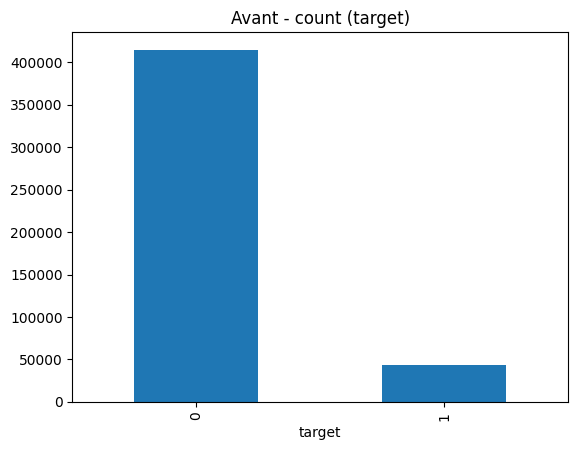

In [94]:
class_0 = df_cleaned[df_cleaned['target'] == 0  ]
class_1 = df_cleaned[df_cleaned['target'] == 1  ]

class_0_under = class_0.sample( len(class_1) )
df_reduced = pd.concat([class_0_under, class_1], axis=0)

df_cleaned['target'].value_counts().plot(kind='bar', title='Avant - count (target)')

<Axes: title={'center': 'Après - count (target)'}, xlabel='target'>

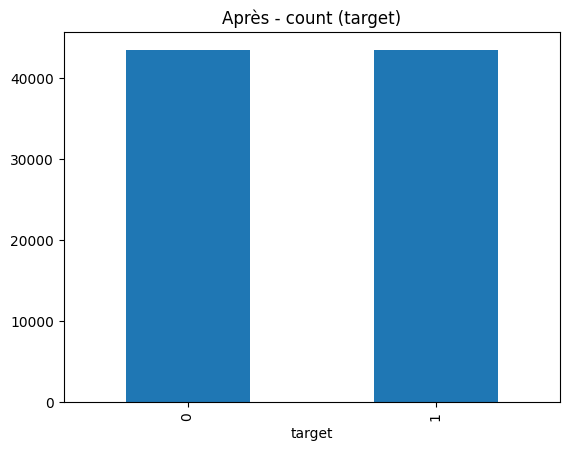

In [95]:
df_reduced['target'].value_counts().plot(kind='bar', title='Après - count (target)')

In [96]:
scaler =  Normalizer()
y = df_reduced['target']
X = df_reduced.drop(['target'], axis=1)
X_scaled = scaler.fit_transform(X, y)

print('Contrôle de la normalisation, est-ce que les données sont bien comprise entre 0 et 1 ?')
print('min', np.min(X_scaled))
print('max', np.max(X_scaled))

Contrôle de la normalisation, est-ce que les données sont bien comprise entre 0 et 1 ?
min 0.0
max 0.9999999999998683


In [97]:
X_train, X_test, y_train, y_test = train_test_split(X, y,train_size=0.9)
X_test, X_val,  y_test, y_val  = train_test_split(X_test, y_test,train_size=0.8)

print(len(X_train))
print(len(X_test))
print(len(X_val))


78343
6964
1741


2024/09/11 15:56:20 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'd2697ea2a7164ce7815471269fd00437', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024/09/11 15:56:20 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\ANTOINE.SARAZIN\.conda\envs\py39\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Mis

0.7245835726593911
0.7242963813900057


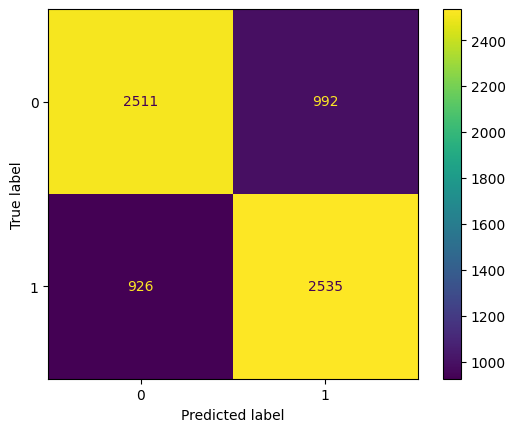

In [98]:
#model tree

dtree_model = DecisionTreeClassifier(max_depth = 5).fit(X_train, y_train) 
dtree_predictions = dtree_model.predict(X_test)  
dtree_Valpredictions = dtree_model.predict(X_val)  

print(accuracy_score(y_test,dtree_predictions))
print(accuracy_score(y_val,dtree_Valpredictions))

cm_dtree = confusion_matrix(y_test, dtree_predictions) 
cm_dtree_display = ConfusionMatrixDisplay(confusion_matrix = cm_dtree, display_labels = [0,1])

cm_dtree_display.plot()
plt.show()

In [63]:
accuracy_dtree = np.trace(cm_dtree) / float(np.sum(cm_dtree))
misclass_dtree = 1 - accuracy_dtree
print(f"Accuracy : {accuracy_dtree}, missclass : {misclass_dtree}")

Accuracy : 0.8322802986789202, missclass : 0.16771970132107983


In [70]:
lg_model = LogisticRegression(random_state=123, solver='liblinear', max_iter=1000).fit(X_train, y_train)
lg_predictions = lg_model.predict(X_test)
lg_predictionsVal = lg_model.predict(X_val)
print(accuracy_score(y_test,lg_predictions))
print(accuracy_score(y_val,lg_predictionsVal))


0.651062607696726
0.6542217116599656


In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

svm_model = SVC().fit(X_train, y_train)
svm_prediction = svm_model.predict(X_test)
svm_Valprediction = svm_model.predict(XVal)

print(accuracy_score(y_test,svm_prediction))
print(accuracy_score(yVal,svm_Valprediction))

0.9231763354394027
0.9103963239517519


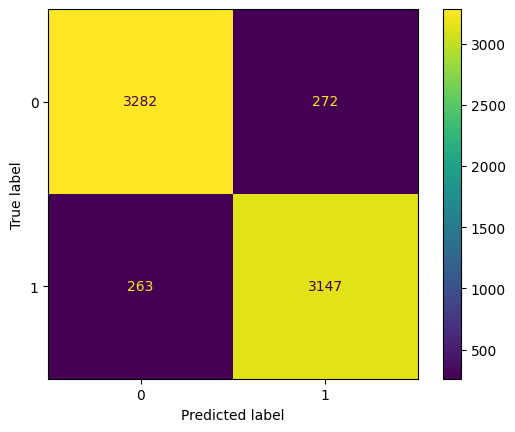

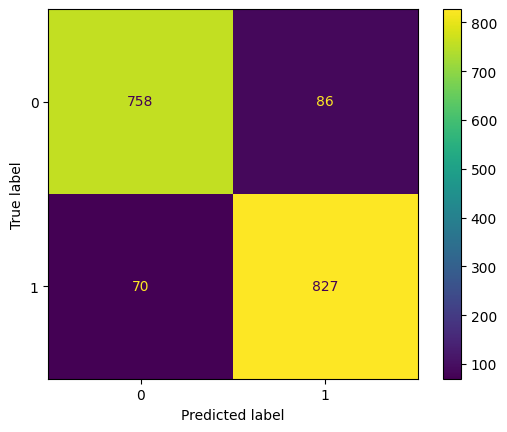

In [66]:
xgbmodel = XGBClassifier()


xgbmodel.fit(X_train, y_train)
xg_prediction = xgbmodel.predict(X_test)
xg_predictionVal = xgbmodel.predict(X_val)

#yval_predX = model.predict(Xval)
print(accuracy_score(y_test,xg_prediction))
print(accuracy_score(y_val,xg_predictionVal))


cm_xgb = confusion_matrix(y_test, xg_prediction) 
cm_xgb_display = ConfusionMatrixDisplay(confusion_matrix = cm_xgb, display_labels = [0,1])

cm_xgb_display.plot()
plt.show()

cm_xgbVal = confusion_matrix(y_val, xg_predictionVal) 
cm_xgb_displayVal = ConfusionMatrixDisplay(confusion_matrix = cm_xgbVal, display_labels = [0,1])

cm_xgb_displayVal.plot()
plt.show()

0.925473865594486
0.9103963239517519


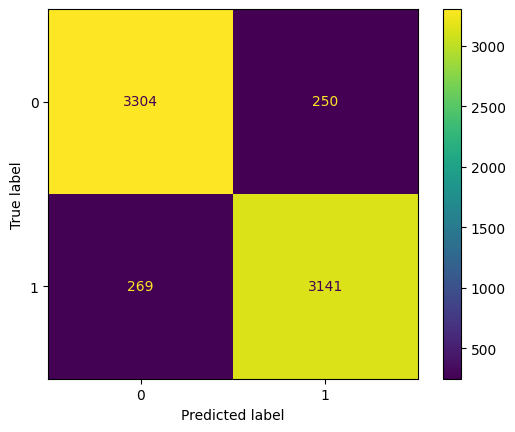

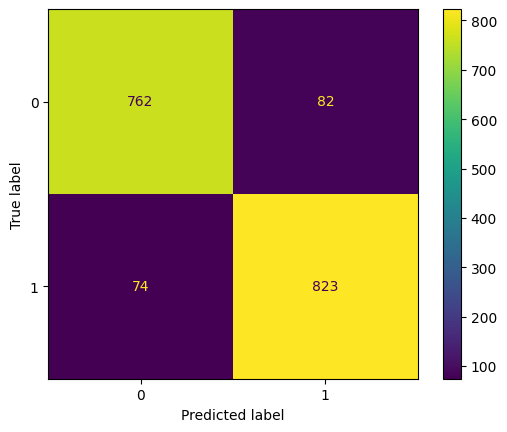

In [67]:

rfcmodel = RandomForestClassifier().fit(X_train, y_train)



rfc_prediction = rfcmodel.predict(X_test)
rfc_predictionVal = rfcmodel.predict(X_val)

#yval_predX = model.predict(Xval)
print(accuracy_score(y_test,rfc_prediction))
print(accuracy_score(y_val,rfc_predictionVal))


cm_rfc = confusion_matrix(y_test, rfc_prediction) 
cm_rfc_display = ConfusionMatrixDisplay(confusion_matrix = cm_rfc, display_labels = [0,1])

cm_rfc_display.plot()
plt.show()


cm_rfcVal = confusion_matrix(y_val, rfc_predictionVal) 
cm_rfc_displayVal = ConfusionMatrixDisplay(confusion_matrix = cm_rfcVal, display_labels = [0,1])

cm_rfc_displayVal.plot()
plt.show()

In [99]:
gen_dirname = os.path.dirname(os.path.abspath('C:\\Users\\ANTOINE.SARAZIN\\Desktop\\machinelearning\\MLOPS\\t'))
print(gen_dirname)

C:\Users\ANTOINE.SARAZIN\Desktop\machinelearning\MLOPS


In [100]:
list_models = []

In [82]:
# Define the model hyperparameters
params_xgb = {

}

# Create model instance
bst = XGBClassifier(**params_xgb)

# Register in list 
list_models.append(["XGBoost3",params_xgb,bst,mlflow.xgboost.autolog])#,model_info])

In [101]:
type_of_dataset = "Jira3"

params_lr = {
    "max_depth": 5,
}

# Create model instance
lr = DecisionTreeClassifier(**params_lr)

# Register in list 
list_models.append(["decisionTreeCL",params_lr,lr,mlflow.sklearn.autolog])#,model_info])


# Define the model hyperparameters
params_lr = {
    "solver": "lbfgs",
    "max_iter": 1000,
    "multi_class": "auto",
    "random_state": 8888,
}

# Create model instance
lr = LogisticRegression(**params_lr)

# Register in list 
list_models.append(["LogisticRegression",params_lr,lr,mlflow.sklearn.autolog])#,model_info])

# Define the model hyperparameters
params_xgb = {
    "n_estimators":5,
    "max_depth":10,
    "learning_rate": 0.3,
    "objective": "binary:logistic",
}

# Create model instance
bst = XGBClassifier(**params_xgb)

# Register in list 
list_models.append(["XGBoost2",params_xgb,bst,mlflow.xgboost.autolog])#,model_info])

from sklearn.ensemble import RandomForestClassifier
params_rf = {
    "n_estimators":100,
    "criterion":"log_loss",
    "max_leaf_nodes":5
}
rf = RandomForestClassifier(**params_rf)
list_models.append(["RandomForest3",params_rf,rf,mlflow.sklearn.autolog])#,model_info])def eval_metrics(actual, preds):

def eval_metrics(actual, preds):
    accuracy = accuracy_score(actual, preds)
    recall = recall_score(actual, preds)
    precision = precision_score(actual, preds)
    cnf_matr = confusion_matrix(actual,preds)
    cnf_matr_nm = cnf_matr.astype('float') / cnf_matr.sum(axis=1)[:, np.newaxis]

    return accuracy, recall, precision, cnf_matr_nm

In [102]:
# Set our tracking server uri for logging
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000") # take care of having the same adress as the one gave when you launched the server

# Create a new MLflow Experiment
mlflow.set_experiment("projetJira3")


for name,params,model,log_model in list_models:

    # Start an MLflow run
    with mlflow.start_run():
        
        log_model()

        # Log the hyperparameters
        mlflow.log_params(params)

        # Fit the model on training data
        model.fit(X_train, y_train)

        log_model(disable=True)
        # Final evaluation on the training sample
        preds_train = model.predict(X_train)

        # Log the train metric
        accuracy_train, recall_train, precision_train, cnf_matr_train = eval_metrics(y_train,preds_train)
        mlflow.log_metric("accuracy_train", accuracy_train)
        mlflow.log_metric("recall_train", recall_train)
        mlflow.log_metric("precision_train", precision_train)

        fig, ax = plt.subplots()

        sns.heatmap(cnf_matr_train, annot=True)
        ax.set_title("Normalized confusion Matrix Train Set", fontsize=14)
        plt.xlabel('Predicted Label')
        plt.ylabel('True label')
        plt.tight_layout()
        plt.close(fig)

        mlflow.log_figure(fig, "normalized_confusion_matrix_train.png")
        
        log_model(disable=False)
        # Make some prediction on the test set
        preds_test = model.predict(X_test)

        # Log the tests metric
        accuracy_test, recall_test, precision_test, cnf_matr_test = eval_metrics(y_test,preds_test)
        mlflow.log_metric("accuracy_test", accuracy_test)
        mlflow.log_metric("recall_test", recall_test)
        mlflow.log_metric("precision_test", precision_test)
        fig, ax = plt.subplots()

        sns.heatmap(cnf_matr_test, annot=True)
        ax.set_title("Normalized confusion Matrix Test Set", fontsize=14)
        plt.xlabel('Predicted Label')
        plt.ylabel('True label')
        plt.tight_layout()
        plt.close(fig)

        mlflow.log_figure(fig, "normalized_confusion_matrix_test.png")

        # Set a tag that we can use to remind ourselves what this run was for
        mlflow.set_tag("Training Info", f"{name} model training for {type_of_dataset} titanic dataset")

        # Every run is tagged with 
        mlflow.set_tag("mlflow.runName", f"{name}")

2024/09/11 15:56:56 INFO mlflow.tracking.fluent: Experiment with name 'projetJira3' does not exist. Creating a new experiment.
2024/09/11 15:56:56 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2024/09/11 15:56:56 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\ANTOINE.SARAZIN\.conda\envs\py39\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer colu

In [103]:
model_name = "XGBOOST_REEDUCEDFEATURE" # To be determined
model_version = "1" # Also to be determined

# Load saved model and make predictions
model_uri = f"models:/{model_name}/{model_version}"
loaded_model = mlflow.pyfunc.load_model(model_uri)

In [108]:
print(X_val)

        Resolution_Time_Minutes  lastUpdated_month  description_wordcount  \
356852                   3020.0                 10                    121   
236365                   1404.0                  8                   1261   
64871                       0.0                  1                    159   
305555                 909480.0                  1                     11   
226608                 201467.0                  2                     48   
...                         ...                ...                    ...   
221319                  10158.0                 10                     70   
235538                   1385.0                 11                     18   
230840                2105845.0                  5                      1   
224379                    855.0                  3                     74   
231402                 125472.0                  3                    802   

        Total_Effort_Minutes  created_month  In_Progress_Minutes  \
356852 

In [157]:
Resolution_Time_Minutes =50000.0
lastUpdated_month = 4 
description_wordcount = 5000
Total_Effort_Minutes = 550.0
created_month = 1
In_Progress_Minutes = 5000.0 
Priority_Medium =20.0

jira_data = pd.DataFrame([[Resolution_Time_Minutes,lastUpdated_month,description_wordcount,Total_Effort_Minutes,created_month,In_Progress_Minutes,Priority_Medium]],columns=["Resolution_Time_Minutes","lastUpdated_month","description_wordcount","Total_Effort_Minutes","created_month","In_Progress_Minutes","Priority_Medium"])

predict_result = loaded_model.predict(jira_data)


if predict_result == 0:
    print("not good")
else:
    print("good")

good
